# Face Detect

In [4]:
import matplotlib.image as mpimg
import json
import time 
import urllib
import requests
import cv2
import operator
import numpy as np
from __future__ import print_function
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline 

_url = 'https://westus.api.cognitive.microsoft.com/face/v1.0/detect'
_key = 'Sua Chave Aqui!'
_maxNumRetries = 10

In [5]:
def processRequest( json, data, headers, params ):

    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _url, json = json, data = data, headers = headers, params = params )

        if response.status_code == 429: 

            print( "Message: %s" % ( response.json()['error']['message'] ) )

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json()['error']['message'] ) )

        break
        
    return result

In [11]:
urlImage = 'http://dujye7n3e5wjl.cloudfront.net/photographs/640-tall/time-100-influential-photos-ellen-degeneres-oscars-selfie-100.jpg'

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/json' 

json = { 'url': urlImage } 
data = None
#params = None
params = urllib.parse.urlencode({
    'returnFaceId': 'true',
    'returnFaceLandmarks': 'true',
    'returnFaceAttributes': 'age,gender,smile,facialHair,headPose,glasses',
})

result = processRequest( json, data, headers, params )

print(result)

[{'faceAttributes': {'gender': 'male', 'smile': 0.01, 'age': 43.1, 'glasses': 'NoGlasses', 'headPose': {'pitch': 0.0, 'yaw': -4.8, 'roll': -2.6}, 'facialHair': {'beard': 0.6, 'sideburns': 0.5, 'moustache': 0.5}}, 'faceLandmarks': {'eyeLeftTop': {'y': 371.5, 'x': 619.6}, 'mouthRight': {'y': 465.6, 'x': 721.3}, 'underLipTop': {'y': 484.6, 'x': 674.5}, 'pupilRight': {'y': 372.1, 'x': 715.3}, 'upperLipTop': {'y': 452.9, 'x': 668.5}, 'eyeRightInner': {'y': 376.1, 'x': 698.8}, 'noseLeftAlarOutTip': {'y': 424.5, 'x': 633.5}, 'noseTip': {'y': 423.5, 'x': 666.4}, 'noseRootRight': {'y': 378.5, 'x': 683.8}, 'eyebrowRightInner': {'y': 352.7, 'x': 692.2}, 'eyebrowLeftOuter': {'y': 362.2, 'x': 579.2}, 'eyeRightTop': {'y': 367.7, 'x': 715.1}, 'eyeLeftInner': {'y': 378.2, 'x': 634.0}, 'noseRightAlarTop': {'y': 406.3, 'x': 692.9}, 'eyeLeftOuter': {'y': 378.8, 'x': 603.7}, 'noseRightAlarOutTip': {'y': 421.3, 'x': 701.8}, 'eyeRightOuter': {'y': 375.1, 'x': 729.8}, 'eyeLeftBottom': {'y': 381.1, 'x': 619.8

In [28]:
def renderResultOnImage( result, img ):
    
    colorRec = (255,0,0)
    
    for currFace in result:
        if currFace['faceAttributes']['gender'] == 'male': 
            colorRec = (255,0,0) 
        else: 
            colorRec = (153,204,50)
        
        faceRectangle = currFace['faceRectangle']
        
        cv2.rectangle( img,(faceRectangle['left'], faceRectangle['top']),
                           (faceRectangle['left'] + faceRectangle['width'], 
                            faceRectangle['top'] + faceRectangle['height']),
                       color = colorRec, thickness = 5 )
        
        currEmotion = currFace['faceAttributes']['gender']

        #writeEmotion = "%s" % ( currEmotion )
        #cv2.putText( img, writeEmotion, (faceRectangle['left'],faceRectangle['top']+20), cv2.FONT_HERSHEY_SIMPLEX, 3, colorRec, 2 )
        
        writeAge = "%s" % (currFace['faceAttributes']['age'])
        cv2.putText( img, writeAge, (faceRectangle['left'],faceRectangle['top']-20), 
                    cv2.FONT_HERSHEY_SIMPLEX, 3, colorRec, 2 )
        
        
        # Obtem os dados da face
        fl = currFace['faceLandmarks']
        
        color = (255,255,255)
        
        # Olho esquerdo
        cv2.circle(img, (int(fl['pupilLeft']['x']), int(fl['pupilLeft']['y'])), 10, color, -1)
        
        # Olho direito
        cv2.circle(img, (int(fl['pupilRight']['x']), int(fl['pupilRight']['y'])), 10, color, -1)
        
        # Nariz
        cv2.circle(img, (int(fl['noseTip']['x']), int(fl['noseTip']['y'])), 10, color, -1)
    
        # Boca
        cv2.circle(img, (int(fl['mouthLeft']['x']), int(fl['mouthLeft']['y'])), 10, color, -1)
        cv2.circle(img, (int(fl['mouthRight']['x']), int(fl['mouthRight']['y'])), 10, color, -1)


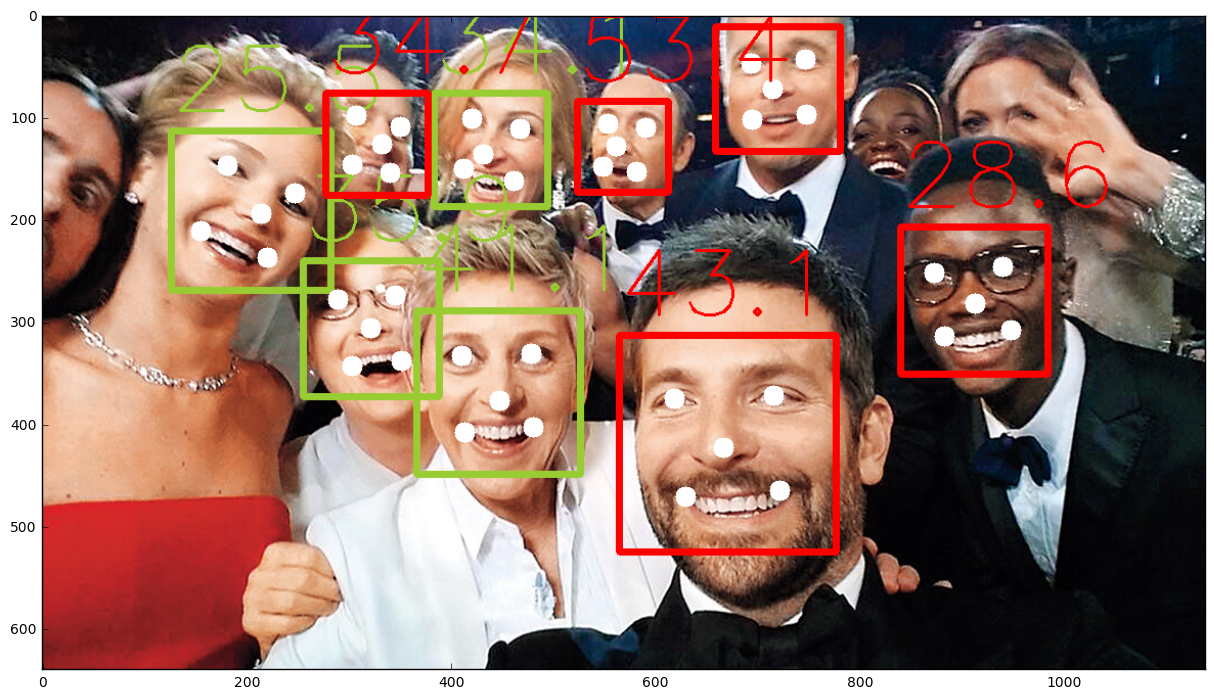

In [29]:
if result is not None:
    # Load the original image, fetched from the URL
    arr = np.asarray( bytearray( requests.get( urlImage ).content ), dtype=np.uint8 )
    img = cv2.cvtColor( cv2.imdecode( arr, -1 ), cv2.COLOR_BGR2RGB )

    renderResultOnImage( result, img )

    ig, ax = plt.subplots(figsize=(15, 20))
    ax.imshow( img )